In [1]:
from pyquil.paulis import *
import numpy as np
from numpy import linalg as LA
import math
import random
import itertools
import cirq
# from cirqqulacs import QulacsSimulatorGpu
import openfermioncirq
from scipy.optimize import minimize
import sympy

In [2]:
model4site = [
    {"U": 2, "neighbors": [1,3], "hoppings": [0,1,0,1]},
    {"U": 2, "neighbors": [0,2], "hoppings": [1,0,1,0]},
    {"U": 2, "neighbors": [1,3], "hoppings": [0,1,0,1]},
    {"U": 2, "neighbors": [0,2], "hoppings": [1,0,1,0]}
]

model4site1d = [
    {"U": 2, "neighbors": [1],   "hoppings": [0,1,0,0]},
    {"U": 2, "neighbors": [0,2], "hoppings": [1,0,1,0]},
    {"U": 2, "neighbors": [1,3], "hoppings": [0,1,0,1]},
    {"U": 2, "neighbors": [2],   "hoppings": [0,0,1,0]}
]

model2site = [
    {"U": 2, "neighbors": [1], "hoppings": [0,1]},
    {"U": 2, "neighbors": [0], "hoppings": [1,0]}
]

model6site = [
    {"U": 2, "neighbors": [1,2,5], "hoppings": [0,1,1,0,0,1]},
    {"U": 2, "neighbors": [0,2,4], "hoppings": [1,0,1,0,1,0]},
    {"U": 2, "neighbors": [0,1,3], "hoppings": [1,1,0,1,0,0]},
    {"U": 2, "neighbors": [2,4,5], "hoppings": [0,0,1,0,1,1]},
    {"U": 2, "neighbors": [1,3,5], "hoppings": [0,1,0,1,0,1]},
    {"U": 2, "neighbors": [0,3,4], "hoppings": [1,0,0,1,1,0]}
]

model8site = [
    {"U": 2, "neighbors": [1,3,7], "hoppings": [0,1,0,1,0,0,0,1]},
    {"U": 2, "neighbors": [0,2,6], "hoppings": [1,0,1,0,0,0,1,0]},
    {"U": 2, "neighbors": [1,3,5], "hoppings": [0,1,0,1,0,1,0,0]},
    {"U": 2, "neighbors": [0,2,4], "hoppings": [1,0,1,0,1,0,0,0]},
    {"U": 2, "neighbors": [3,5,7], "hoppings": [0,0,0,1,0,1,0,1]},
    {"U": 2, "neighbors": [2,4,6], "hoppings": [0,0,1,0,1,0,1,0]},
    {"U": 2, "neighbors": [1,5,7], "hoppings": [0,1,0,0,0,1,0,1]},
    {"U": 2, "neighbors": [0,4,6], "hoppings": [1,0,0,0,1,0,1,0]}
]

t = t2 = t3 = 1
modelGutzwiller = [
    {"U": 2, "neighbors": [1,3,5], "hoppings": [0,t,0,t,0,t2,0,0]},
    {"U": 2, "neighbors": [0,2,6], "hoppings": [t,0,t,0,0,0,t2,0]},
    {"U": 2, "neighbors": [1,3,7], "hoppings": [0,t,0,t,0,0,0,t2]},
    {"U": 2, "neighbors": [0,2,4], "hoppings": [t,0,t,0,t2,0,0,0]},
    {"U": 0, "neighbors": [3,5,7], "hoppings": [0,0,0,t2,0,t3,0,t3]},
    {"U": 0, "neighbors": [0,4,6], "hoppings": [t2,0,0,0,t3,0,t3,0]},
    {"U": 0, "neighbors": [1,5,7], "hoppings": [0,t2,0,0,0,t3,0,t3]},
    {"U": 0, "neighbors": [2,4,6], "hoppings": [0,0,t2,0,t3,0,t3,0]}
]

model12site1d = [
    {"U": 2, "neighbors": [1],   "hoppings": [0,1,0,0,0,0,0,0,0,0,0,0]},
    {"U": 2, "neighbors": [0,2], "hoppings": [1,0,1,0,0,0,0,0,0,0,0,0]},
    {"U": 2, "neighbors": [1,3], "hoppings": [0,1,0,1,0,0,0,0,0,0,0,0]},
    {"U": 2, "neighbors": [2,4], "hoppings": [0,0,1,0,1,0,0,0,0,0,0,0]},
    {"U": 2, "neighbors": [3,5], "hoppings": [0,0,0,1,0,1,0,0,0,0,0,0]},
    {"U": 2, "neighbors": [4,6], "hoppings": [0,0,0,0,1,0,1,0,0,0,0,0]},
    {"U": 2, "neighbors": [5,7], "hoppings": [0,0,0,0,0,1,0,1,0,0,0,0]},
    {"U": 2, "neighbors": [6,8], "hoppings": [0,0,0,0,0,0,1,0,1,0,0,0]},
    {"U": 2, "neighbors": [7,9], "hoppings": [0,0,0,0,0,0,0,1,0,1,0,0]},
    {"U": 2, "neighbors": [8,10],"hoppings": [0,0,0,0,0,0,0,0,1,0,1,0]},
    {"U": 2, "neighbors": [9,11],"hoppings": [0,0,0,0,0,0,0,0,0,1,0,1]},
    {"U": 2, "neighbors": [10],  "hoppings": [0,0,0,0,0,0,0,0,0,0,1,0]}
]

model = model4site
N = len(model)
qb = [cirq.LineQubit(i) for i in range(N*2)]
print(N)

4


In [4]:
from cirq import PauliString

def U():
    """
    Builds the interaction term: a_p^dagger a_q^dagger a_q a_p
    """    
    hamiltonian = PauliString(0)
    for i in range(N):
        hamiltonian += (model[i]["U"] / 4) * (PauliString(cirq.I(qb[i])) - PauliString(cirq.Z(qb[i])) - PauliString(cirq.Z(qb[i+N])) + PauliString(cirq.Z(qb[i])*cirq.Z(qb[i+N])))

    return hamiltonian

def t():
    """
    Builds the hopping term: a_p^dagger a_q
    """
    def op(s1, s2):
        """
        returns a PauliSum representing a_s1^daggar a_s2
        """    
        # for all sites in between site one (s1) and site two (s2), multiply by sigma z
        z = cirq.I(qb[0])
        for i in range(s1+1, s2):
            z *= cirq.Z(qb[i])

        return PauliString(cirq.X(qb[s1])) * z * PauliString(cirq.X(qb[s2])) + PauliString(cirq.Y(qb[s1])) * z * PauliString(cirq.Y(qb[s2]))
        
    hops = []
    for i in range(N):
        n = model[i]["neighbors"]
        for j in range(len(n)):
            # if a hopping is not already in the array i.e. don't add (3,0) if (0,3) is there
            if (i, n[j]) in hops or (n[j], i) in hops or i == n[j]:
                pass
            else:
                hops.append((i, n[j]))
                
    hamiltonian = PauliString(0)
    for hop in hops:
        # add hoppings for up and down spins
        hamiltonian += (-model[hop[0]]["hoppings"][hop[1]]) * op(hop[0], hop[1])
    for hop in hops:
        hamiltonian += (-model[hop[0]]["hoppings"][hop[1]]) * op(hop[0]+N, hop[1]+N)
    return hamiltonian * (1/2)

hamU = U()
hamt = t()

hamiltonian = hamU + hamt
print(hamiltonian)

2.000*I-0.500*Z(0)-0.500*Z(4)+0.500*Z(0)*Z(4)-0.500*Z(1)-0.500*Z(5)+0.500*Z(1)*Z(5)-0.500*Z(2)-0.500*Z(6)+0.500*Z(2)*Z(6)-0.500*Z(3)-0.500*Z(7)+0.500*Z(3)*Z(7)-0.500*X(0)*X(1)-0.500*Y(0)*Y(1)-0.500*X(0)*Z(1)*Z(2)*X(3)-0.500*Y(0)*Z(1)*Z(2)*Y(3)-0.500*X(1)*X(2)-0.500*Y(1)*Y(2)-0.500*X(2)*X(3)-0.500*Y(2)*Y(3)-0.500*X(4)*X(5)-0.500*Y(4)*Y(5)-0.500*X(4)*Z(5)*Z(6)*X(7)-0.500*Y(4)*Z(5)*Z(6)*Y(7)-0.500*X(5)*X(6)-0.500*Y(5)*Y(6)-0.500*X(6)*X(7)-0.500*Y(6)*Y(7)


In [5]:
def U_ansatz(param):
    """
    Creates a circuit for e^{i \theta_U H_U}
    """
    for i in range(N):
        yield cirq.rz(model[i]["U"]*param/4)(qb[i])
        yield cirq.rz(model[i]["U"]*param/4)(qb[i+N])
        yield cirq.CNOT(qb[i], qb[i+N])
        yield cirq.rz(-model[i]["U"]*param/4)(qb[i+N])
        yield cirq.CNOT(qb[i], qb[i+N])

In [6]:
def t_ansatz(s1, s2, param):
    """
    Creates a circuit for e^{i \theta_t H_t} for horizontal and vertical hoppings
    """    
    for i in range(s1+1, s2):
        if (i == s2-1):
            yield cirq.CZ(qb[i], qb[i+1])
        else:
            yield cirq.CNOT(qb[i], qb[i+1])

    yield cirq.H(qb[s1])    
    yield cirq.H(qb[s2])    
    yield cirq.CNOT(qb[s1], qb[s2])
    yield cirq.rz(param)(qb[s2])
    yield cirq.CNOT(qb[s1], qb[s2])
    yield cirq.H(qb[s1])    
    yield cirq.H(qb[s2]) 
    yield cirq.rx(-np.pi/2)(qb[s1])
    yield cirq.rx(-np.pi/2)(qb[s2])
    yield cirq.CNOT(qb[s1], qb[s2])
    yield cirq.rz(param)(qb[s2])
    yield cirq.CNOT(qb[s1], qb[s2])
    yield cirq.rx(-np.pi/2)(qb[s1])
    yield cirq.rx(-np.pi/2)(qb[s2])
    
    for i in reversed(range(s1+1, s2)):
        if (i == s2-1):
            yield cirq.CZ(qb[i], qb[i+1])
        else:
            yield cirq.CNOT(qb[i], qb[i+1])
    return c

In [7]:
# This is from the pyquil code, I am not sure what this cell is doing so I don't know how to convert it to qulacs
# The main issue was from how the model was set up in pyquil. Since I have to explicitly write the hamiltonian,
# I still am figuring out how to work with the neighbors and hopping terms

simplified_h_t =  np.array([[ 0.0 for i in range(N)] for j in range(N)])
for i in range(N):
    for j in model[i]["neighbors"]:
        simplified_h_t[i][j] = -1.0
# for i in range(N):
#     simplified_h_t[i][N-1-i] = -0.99
print(simplified_h_t)
w2, v2 = LA.eigh(simplified_h_t)

for i in range(N):
    print(w2[i], v2[:,i])

[[ 0. -1.  0. -1.]
 [-1.  0. -1.  0.]
 [ 0. -1.  0. -1.]
 [-1.  0. -1.  0.]]
-2.0 [0.5 0.5 0.5 0.5]
-4.5102810375396984e-17 [-7.07106781e-01 -2.45326947e-17  7.07106781e-01 -2.45326947e-17]
0.0 [ 0.         -0.70710678  0.          0.70710678]
2.0 [ 0.5 -0.5  0.5 -0.5]


In [10]:
# Q = get_mo(h1, eri, N)
Q = np.array(
[[1., 0., 0., 0.],
 [0., 1., 0., 0.]]
 )


print(Q)
from openfermion.utils import slater_determinant_preparation_circuit

def prepare_slater_determinant(Q): 
    """
    Prepares the Slater determinant as described in https://arxiv.org/pdf/1711.05395.pdf
    
    Args:
        Q: The (N_f x N) matrix Q with orthonormal rows which describes the Slater determinant to be prepared.
    Returns:
        c: A program that applies the sequence of Givens rotations returned 
            from slater_determinant_preparation_circuit
    """

    # Q is a (N_f x N) matrix
    # N = Q[0].size, number of sites
    N_f = len(Q)
    
    givens = slater_determinant_preparation_circuit(Q)

    def givens_rotation(tups, spin):
        """
        Performs Givens rotations
        
        Args:
            tups: tuple containing Givens rotations to be performed together
            spin: 0 represents up spin, and 1 represents down spin
        Returns:
            p: A program that applies the Givens rotations in tups
        """
        for tup in tups:
            # where tup is (j, k, theta, phi)
            # yield cirq.CNOT(qb[tup[1]+(N*spin)], qb[tup[0]+(N*spin)])
            yield cirq.CNOT(qb[tup[1]+(N*spin)], qb[tup[0]+(N*spin)])

            # controlled-RY
            yield cirq.YPowGate(exponent=tup[2] / np.pi, global_shift=-0.5).controlled(1)(qb[tup[0]+N*spin], qb[tup[1]+(N*spin)])

            yield cirq.CNOT(qb[tup[1]+(N*spin)], qb[tup[0]+(N*spin)])
            yield cirq.rz(tup[3])(qb[tup[1]+(N*spin)]) # all psis are zero, anyway
    
    c = cirq.Circuit()

    # Fill first N_f orbitals for each spin
    for i in range(N_f):
        c.append(cirq.X(qb[i]))
        c.append(cirq.X(qb[i+N]))

    # Perform Givens rotations for up and down spins
    for rot in givens:
        c.append(givens_rotation(rot, 0))
        c.append(givens_rotation(rot, 1))

    return c

c = cirq.Circuit()
c = prepare_slater_determinant(Q)
res = QulacsSimulatorGpu().simulate(c)
qb_map = {qb[i]: i for i in range(N*2)}
r = res._final_simulator_state
print()
print(slater_determinant_preparation_circuit(Q))
print()
print(c)
print()
print(hamiltonian.expectation_from_wavefunction(res._final_simulator_state, qb_map))

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]


NameError: name 'QulacsSimulatorGpu' is not defined

In [122]:
from openfermioncirq import prepare_slater_determinant
c = cirq.Circuit()
c.append(prepare_slater_determinant(qb[:N], Q))
c.append(prepare_slater_determinant(qb[N:], Q))
print(c)
s = cirq.Simulator()
res = s.simulate(c)
qb_map = {qb[i]: i for i in range(N*2)}
print(hamiltonian.expectation_from_state_vector(res._final_simulator_state.state_vector, qb_map))

0: ───X───

1: ───X───

4: ───X───

5: ───X───


ValueError: Input qubit map indices must be valid for a state over 4 qubits.

In [8]:
# convert to hopping direction matrix
for i in range(N):
    simplified_h_t[i][N-1-i] *= -1

hops = []
for j in range(N):
    n = model[j]["neighbors"]
    for k in range(len(n)):
        # if a hopping is not already in the array i.e. don't add (3,0) if (0,3) is there
        if (j, n[k]) in hops or (n[k], j) in hops or j == n[k]:
            pass
        else:
            hops.append((j, n[k]))
h_hops = []
v_hops = []
for hop in hops:
    if (simplified_h_t[hop[0]][hop[1]] < 0):
        h_hops.append(hop)
    else:
        v_hops.append(hop)

print(simplified_h_t)
print(h_hops)
print(v_hops)

def var_ansatz(params):
    """
    Prepares \sum_S [U_U(\theta_U / 2) U_h(\theta_h) U_v(\theta_v) U_U(\theta_U / 2)] | \Psi_I >
    Where | \Psi_I > is the Slater determinant for U = 0
    """
    S = 1
    c = cirq.Circuit()
    c = prepare_slater_determinant(Q)
    
    for i in range(S):
        # building U_u
        c.append(U_ansatz(params[3*i]))

        # building U_t, horizontal and vertical
        # up spin horizontal hops
        for hop in h_hops:
            c.append(t_ansatz(hop[0], hop[1], params[3*i+1]))
        # down spin horizontal hops
        for hop in h_hops:
            c.append(t_ansatz(hop[0]+N, hop[1]+N, params[3*i+1]))

        # up spin vertical hops
        for hop in v_hops:
            c.append(t_ansatz(hop[0], hop[1], params[3*i+2]))
        # down spin vertical hops
        for hop in v_hops:
            c.append(t_ansatz(hop[0]+N, hop[1]+N, params[3*i+2]))
    
        # building U_u
        c.append(U_ansatz(params[3*i]))
        
    return c

[[ 0. -1.  0.  1.]
 [-1.  0.  1.  0.]
 [ 0.  1.  0. -1.]
 [ 1.  0. -1.  0.]]
[(0, 1), (2, 3)]
[(0, 3), (1, 2)]


<Figure size 432x288 with 0 Axes>

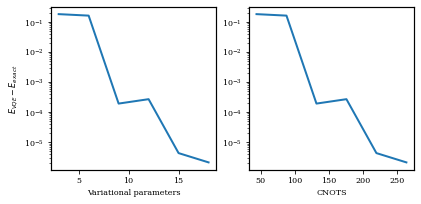

In [50]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Palatino'] + plt.rcParams['font.serif']
plt.rc('axes', linewidth=1.2)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.tight_layout()

params = [3,6,9,12,15,18]
cnots = [44 * x/3 for x in params]
es = [-3.15868112, -3.17829569, -3.34065549, -3.34057843, -3.3408433, -3.3408455]
E = -3.34084762 
diff = [abs(E - x) for x in es]

fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))

ax[0].plot(params, diff, linewidth=2)
ax[0].set_yscale('log')
ax[0].set_ylabel('$E_{VQE} - E_{exact}$')
ax[0].set_xlabel('Variational parameters')

ax[1].plot(cnots, diff, linewidth=2)
ax[1].set_yscale('log')
ax[1].set_xlabel('CNOTS')

plt.savefig('converge.png', dpi=300, transparent=False, bbox_inches='tight')

In [21]:
diff

[0.18216650000000012,
 0.1625519299999998,
 0.00019212999999984604,
 0.00026919000000003024,
 4.319999999946589e-06,
 2.1199999999943486e-06,
 4.160000000030806e-06]

In [19]:
symbols = [sympy.Symbol('p{}'.format(i)) for i in range(3)]

def expectation(x):
    """
    Expectation value for parameters, x
    """
    c = var_ansatz(symbols)
    resolver = cirq.ParamResolver({'p{}'.format(i):x[i] for i in range(3)})
    resolved_c = cirq.resolve_parameters(c, resolver)
    res = QulacsSimulatorGpu().simulate(resolved_c)
    return hamiltonian.expectation_from_wavefunction(res._final_simulator_state, qb_map).real

def scipy_minimize(x):
    """
    Minimizes expectation value using parameters found in greedy search as starting point
    Powell's conjugate direction method
    """
    return minimize(expectation, x, method='Powell')

def greedy_noisy_search(initial_state):
    """
    Slightly perturb the values of the points, accepting whenever this results in a lower energy
    Total of 150 evaulations of the energy
    Change step size after 30 evaluations based on number of acceptances in previous trial group
    """
    params = initial_state
    min_energy = expectation(initial_state)

    def random_point(dim, step):
        """
        Generates a random point on the perimeter of a circle with radius, step
        """
        coords = [random.gauss(0, 1) for i in range(dim)]
        norm = math.sqrt(sum([i**2 for i in coords]))
        coords = [(i / norm) * step for i in coords]
        return coords

    step = 0.1
    acceptances = 0

    # Five groups of 30 trials
    for i in range(5):
        acceptances = 0
        for j in range(30):
            
            # Slightly perturb the values of the points
            coords = random_point(len(initial_state), step)
            temp_params = [sum(x) for x in zip(params, coords)]
            
            # Calculate expectation value with new parameters
            temp_energy = expectation(temp_params)
            
            # Greedily accept parameters that result in lower energy
            if (temp_energy < min_energy):
                min_energy = temp_energy
                params = temp_params
                acceptances += 1
        # Update step size
        step *= (acceptances / 15)

    return {'x': params, 'energy': min_energy, 'step': step}

def global_variational(initial_params=[]):
    """
    Complete a round of greedy and Powell's optimization for six randomly chosen points
    Further optimizes the best point
    """
    points = [np.random.rand(3)*0.5 for i in range(6)]
    greedy_results = [greedy_noisy_search(x) for x in points]
    print("Done with greedy search")
    # change it to only optimize the lowest three energies
    # results = [scipy_minimize(i['x']) for i in sorted(greedy_results, key=lambda x:x['x'])[:5]]
    results = [scipy_minimize(i['x']) for i in greedy_results]
    print("Done with Powell's")
    res = min(results, key=lambda x:x.fun)
    print(res)
    # For the chosen point, we continue optimizing until we cannot find improvement
    res_copy = res
    energy = res_copy.fun
    while (True):
        result = greedy_noisy_search(res_copy.x)
        temp_res = scipy_minimize(result['x'])
        temp_energy = temp_res.fun
        print(temp_energy)

        # Optimizing will usually find an energy ~1e-6 lower
        # Stop it eventually
        tolerance = 0.01
        if (abs(temp_energy - energy) > tolerance):
            res_copy = temp_res
            energy = temp_energy
        else:
            break
    return res_copy

In [20]:
res = global_variational()
print(res)

Done with greedy search
Done with Powell's
   direc: array([[-0.49553824,  0.00926581, -0.00590371],
       [-0.4242824 ,  0.03369534,  0.02649956],
       [-0.32769075,  0.00294815,  0.00694866]])
     fun: array(-3.15853231)
 message: 'Optimization terminated successfully.'
    nfev: 232
     nit: 6
  status: 0
 success: True
       x: array([-2.92331396,  0.70766059, -0.06968298])
-3.1586708193334303
   direc: array([[-0.49553824,  0.00926581, -0.00590371],
       [-0.4242824 ,  0.03369534,  0.02649956],
       [-0.32769075,  0.00294815,  0.00694866]])
     fun: array(-3.15853231)
 message: 'Optimization terminated successfully.'
    nfev: 232
     nit: 6
  status: 0
 success: True
       x: array([-2.92331396,  0.70766059, -0.06968298])
